<a href="https://colab.research.google.com/github/Yuma-Ichikawa/statistical-physics-methods-opt-ml-ja/blob/main/Ex1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks

# Defoult Setting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 10  # 適当に必要なサイズに
plt.rcParams['xtick.direction'] = 'in'  # in or out
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["mathtext.fontset"] = "stix" # stix fontにする(Latexのfont)

plt.style.use('seaborn')

# fix seed
np.random.seed(0)

## Exercise 1.4 - Metropolis-Hastings algorithm for Curie-Weiss

初期配位は, $S(0)= (1,\dots, 1)$とする. 

また, Curie-Weiss模型のHamiltonian
$$\mathcal{H}_{N}(S) = - \frac{1}{2N} \sum_{ij} S_{i} S_{j} - h \sum_{i} S_{i}$$

の場合, $\Delta E = E_{\mathrm{now}} - E_{\mathrm{flip}}$は以下のように評価できる.

\begin{align} E_{\mathrm{now}} - E_{\mathrm{flip}} &= - N \left(\frac{1}{2} \bar{S}^{2} + h \bar{S}  \right) - \frac{N}{2} \left(\bar{S} - \frac{2S_{i}}{N}  \right)^{2} - N h \left(\bar{S} - \frac{2 S_{i}}{N}  \right) \\ &= 2S_{i}\left(\bar{S} - \frac{1}{N} S_{i} + h  \right) \end{align}

この式を用いMetropolisの一回updateを実装する.

In [2]:
def metropolis_update(S: np.ndarray, beta: float, h: float) -> np.ndarray:
    """一回のMetropolis Update
    
    Parameters
    ----------
    S : ndarray of shape (N, )
        spin configuration at time t
    beta : float
           inverse temperature
    h : float
        magnetic field 

    Returns
    ---------
    S : ndarray of shape (N, )
        spin configuration at time t+1
    """
    
    # randomにスピンを選択
    i = np.random.randint(low=0, high=len(S)) 
    # エネルギー差を計算
    dE = 2*S[i]*(np.mean(S) -S[i]/len(S) + h)  
    # accept or reject
    if np.random.random() < np.exp(-beta * dE):
        S[i] = -S[i] 
    return S

In [3]:
def MH_MCMC(beta, h, S0, steps = 10000) -> np.ndarray:
    """Metropolis-Hasting MCMC
    
    Parameters
    ----------
    beta : float
           inverse temperature
    h : float
        magnetic field 
    S0 : ndarray of shape (N, )
        initial configuratioin 
    num_step : int
                number of steps

    Returns
    ---------
    S : ndarray of shape (N, )
        spin configuration at time t+1
    """
    S = S0.copy()
    m = np.zeros(0)
    for t in np.arange(steps-1):
        m = np.hstack([m, np.mean(S)])
        S = metropolis_update(S, beta, h)

    return m

In [4]:
# 理論値を取得する関数
def H(m):
    return - 0.5*((1+m) * np.log((1+m)/2) + (1-m)*np.log((1-m)/2))

def potential(m, beta, h):
    return 0.5*beta*(m**2) + beta*h*m + H(m)

def get_mstar(beta, h):
    ms = np.linspace(-0.999, 0.999, 1000)
    pot = potential(ms, beta, h)
    # peakを持つindexを取得
    peaks = find_peaks(pot)[0]
    return [ms[peak] for peak in peaks]

Minima at m=[-0.659, 0.6590000000000001]


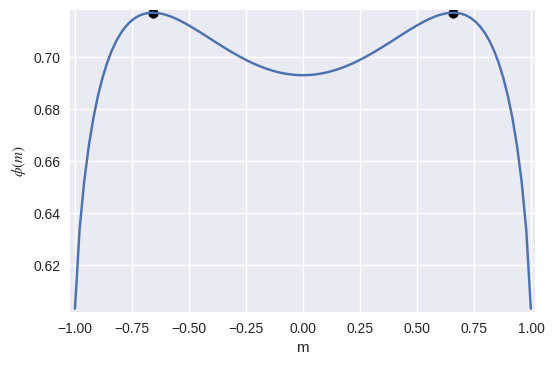

In [7]:
h = 0
beta = 1.2
mstars = get_mstar(beta, h)

print('Minima at m={}'.format(mstars))

ms = np.linspace(-0.999,0.999, 100)
pot = potential(ms, beta, h)

fig, ax = plt.subplots(dpi=100)
ax.plot(ms, pot, label=r'$\beta={}$'.format(beta))

for mstar in mstars:
    ax.scatter([mstar], [potential(mstar, beta, h)], marker='o', color='black')

ax.set_xlabel('m')
ax.set_ylabel(r'$\phi(m)$')

plt.show()

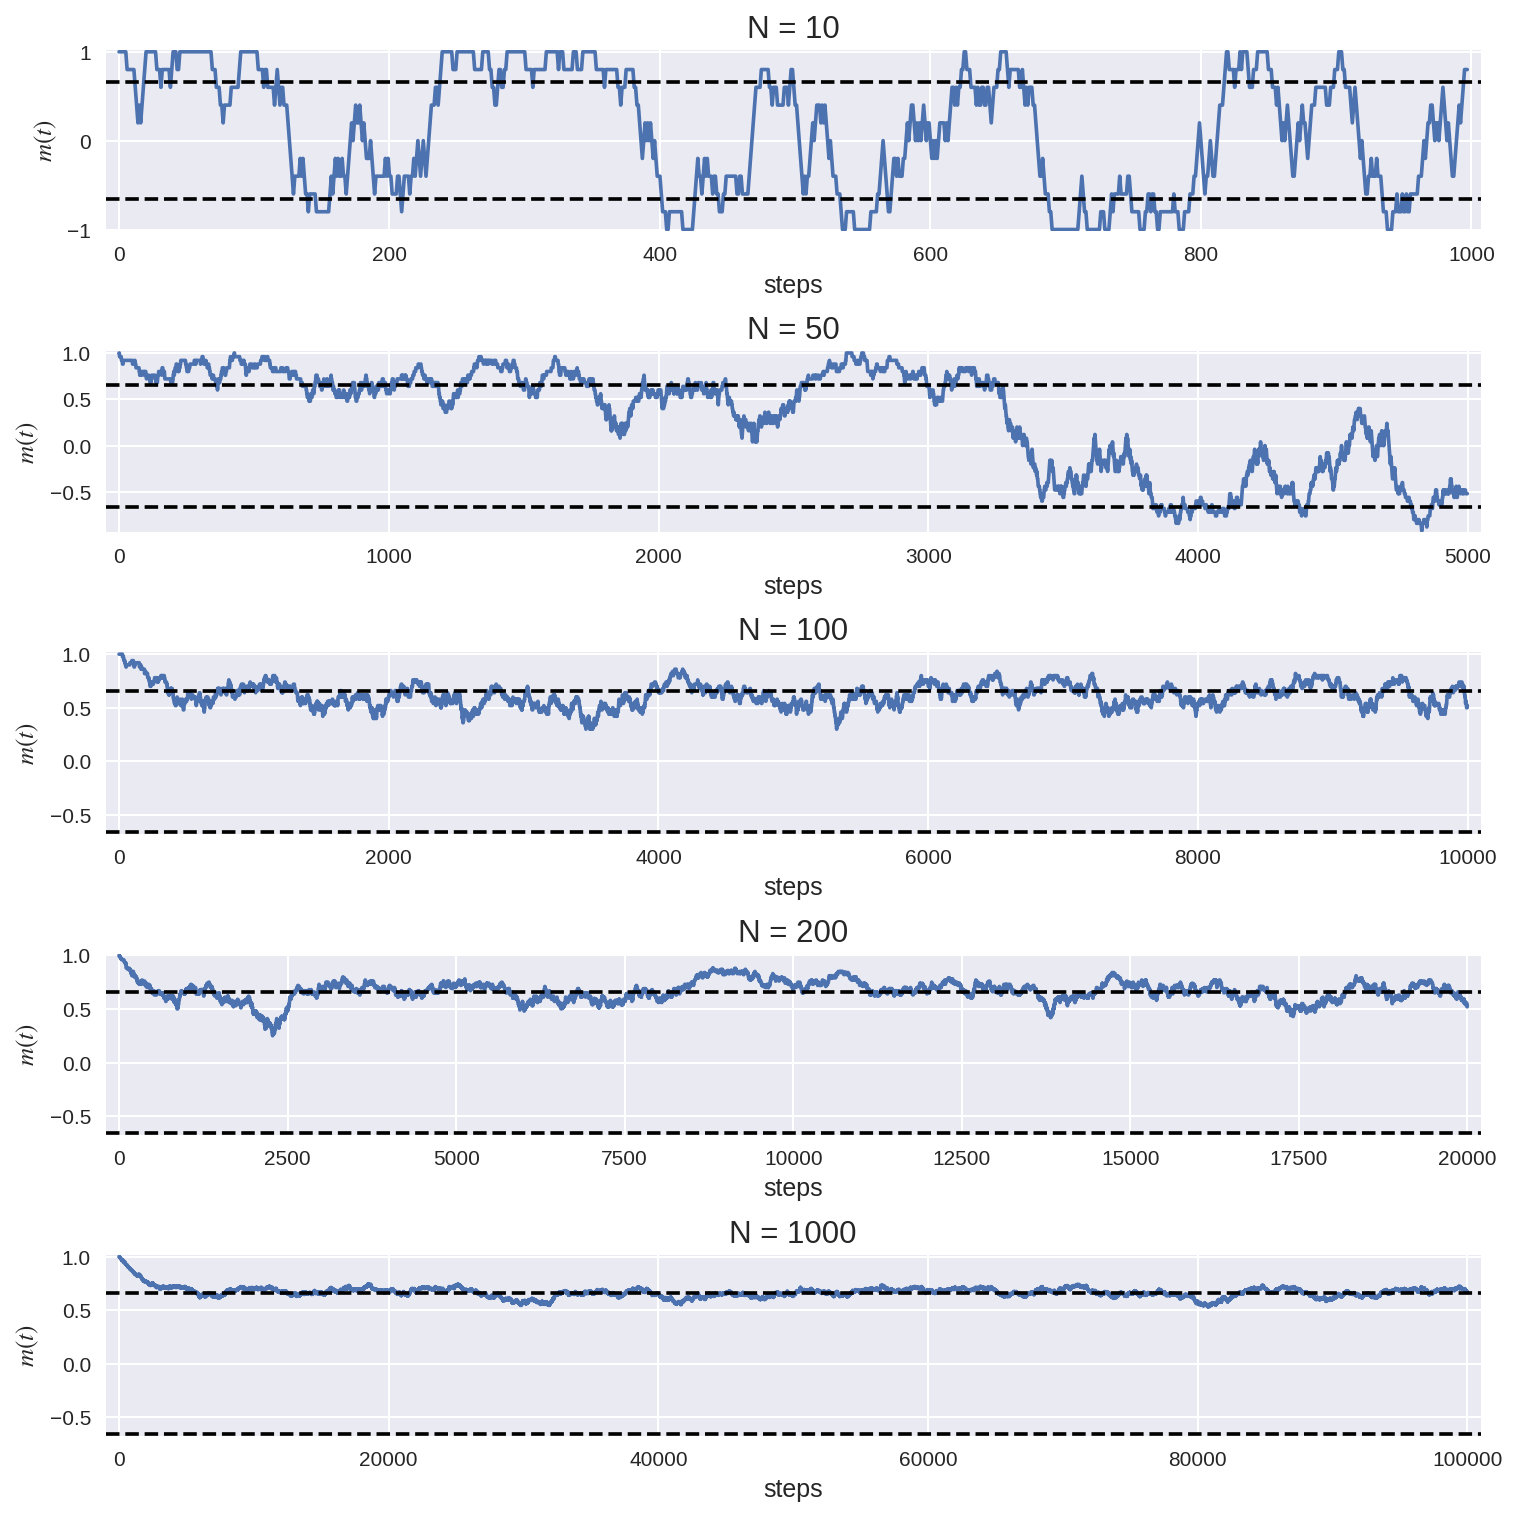

In [11]:
h = 0
beta = 1.2

fig, ax = plt.subplots(5, 1, figsize=(10, 10), dpi=150, constrained_layout=True)
for i, N, in enumerate([10, 50, 100, 200, 1000]):
    # initial spins
    S0 = np.ones(N)
    ms = MH_MCMC(beta, h, S0, steps = 100*N)
    
    ax[i].plot(ms[:-1])
    for mstar in mstars:
        ax[i].axhline(mstar, color='k', ls='--')

    ax[i].set_title(f'N = {N}', fontsize=15)
    ax[i].set_xlabel('steps', fontsize=12)
    ax[i].set_ylabel(r'$m(t)$', fontsize=12)

$\beta = 1.2$, $h=0$では, $\phi(m)$に2つの対称な大域的最適解が存在する. この2つの値は, 系の平衡状態の値に対応する. Metropolis-Hastingsアルゴリズムの各ステップでは, 1つのスピンをさせることを思い出すと, 磁化$m^{\ast}$と磁化$-m^{\ast}$の間の典型的な時間は$t \sim e^{N}$のオーダーである. アルゴリズムを$\bar{S} = (1, \ldots, 1)$で初期化しているため, $m^{\ast}$に近く, $N \to \infty$では磁化$m^{\ast}$に到達する. しかし, 数値的には常に有限の$N$となるため, $t=e^{N}$だけアルゴルリズムを実行すると$-m^{\ast}$に到達する可能性もある. 実際, $N=10,50$の場合, そのような現象が見られる(有限サイズ効果). 

Minima at m=[-0.787]


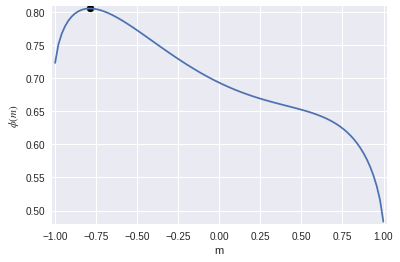

In [12]:
h = -0.1
beta = 1.2
mstars = get_mstar(beta, h)

print('Minima at m={}'.format(mstars))

ms = np.linspace(-0.999,0.999, 100)
pot = potential(ms, beta, h)

fig, ax = plt.subplots()
ax.plot(ms, pot, label=r'$\beta={}$'.format(beta))

for mstar in mstars:
    ax.scatter([mstar], [potential(mstar, beta, h)], marker='o', color='black')

ax.set_xlabel('m')
ax.set_ylabel(r'$\phi(m)$')

plt.show()

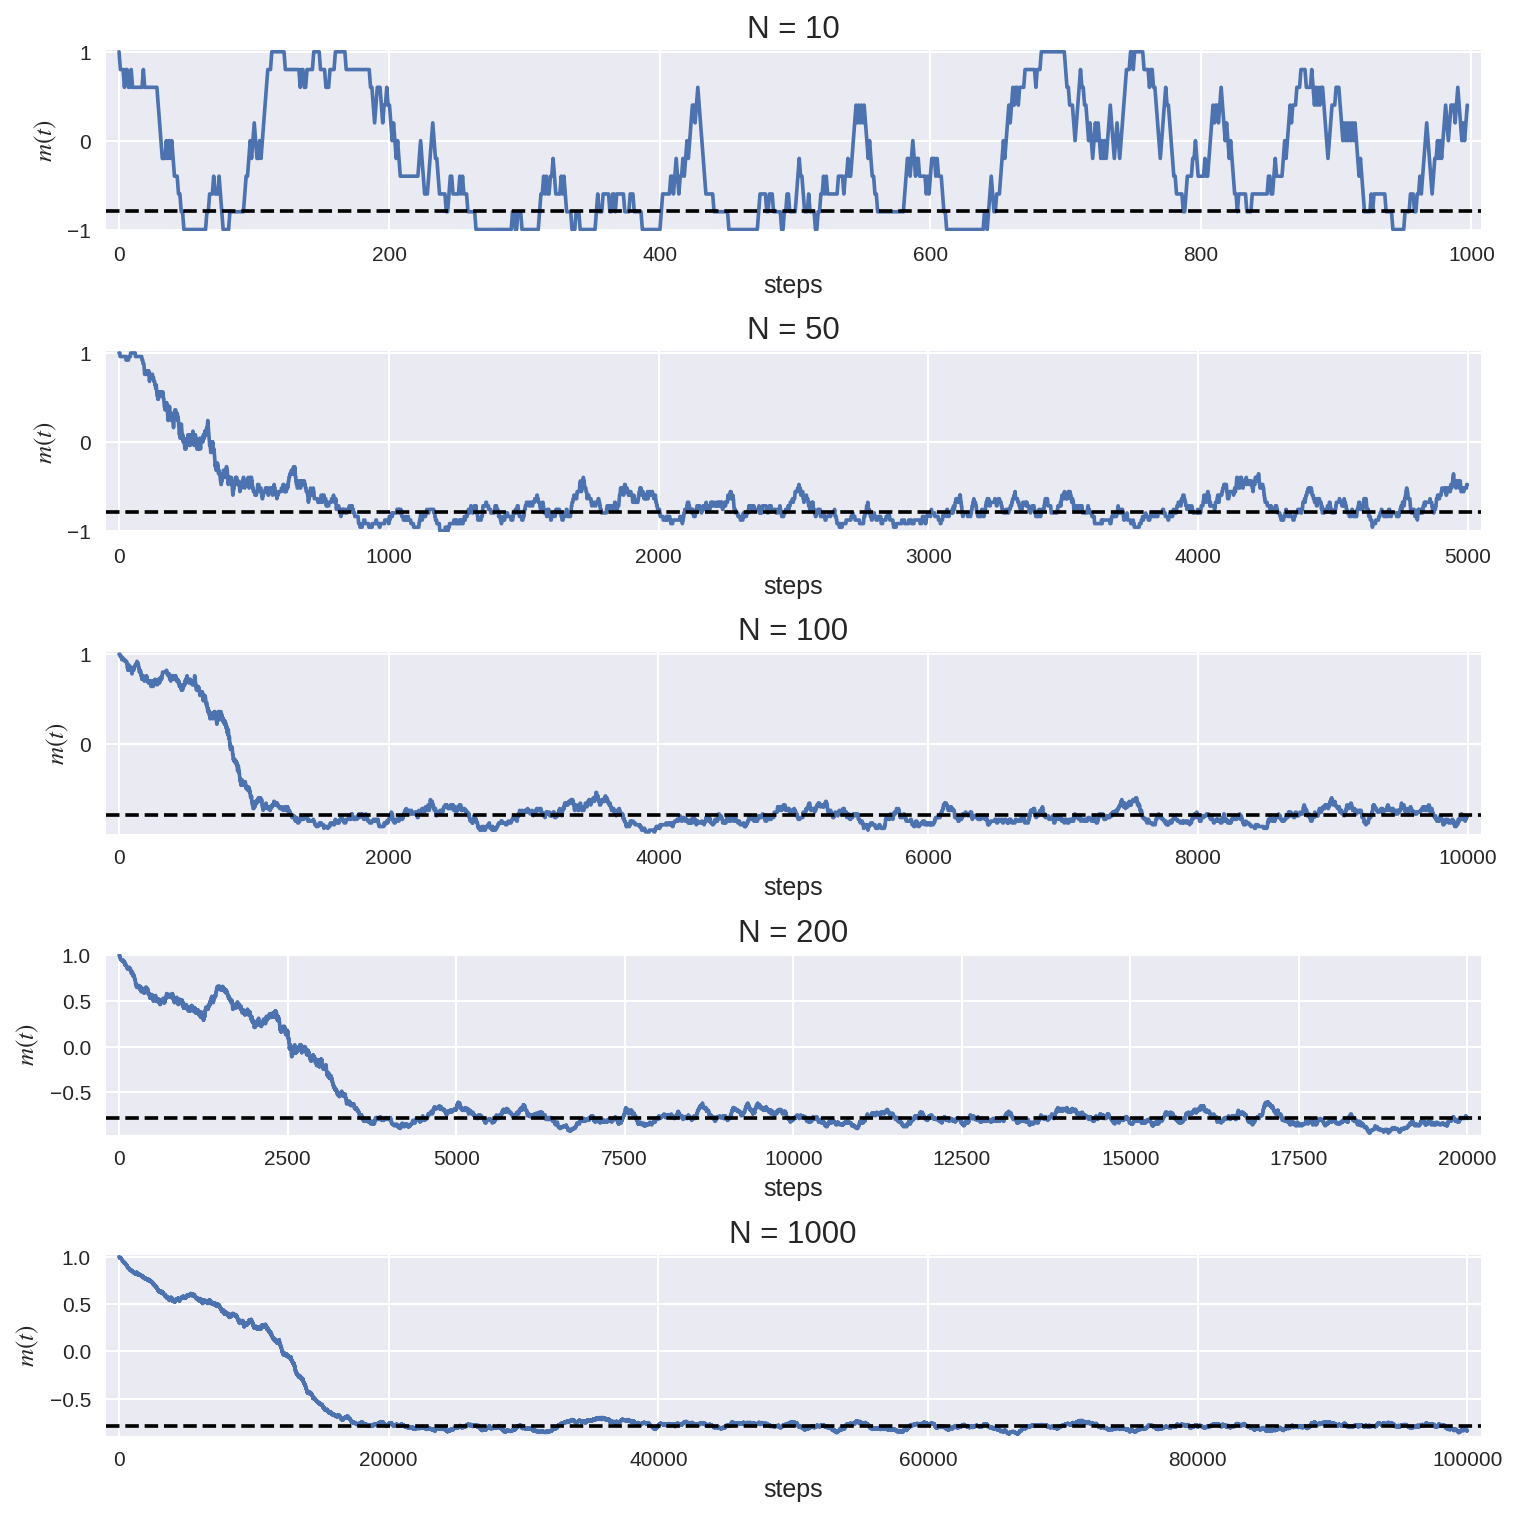

In [13]:
h = -0.1
beta = 1.2

fig, ax = plt.subplots(5, 1, figsize=(10, 10), dpi=150, constrained_layout=True)
for i, N, in enumerate([10, 50, 100, 200, 1000]):
    # initial spins
    S0 = np.ones(N)
    ms = MH_MCMC(beta, h, S0, steps = 100*N)
    
    ax[i].plot(ms[:-1])
    for mstar in mstars:
        ax[i].axhline(mstar, color='k', ls='--')

    ax[i].set_title(f'N = {N}', fontsize=15)
    ax[i].set_xlabel('steps', fontsize=12)
    ax[i].set_ylabel(r'$m(t)$', fontsize=12)

## Exercise 1.5 - Glauber algorithm for Curie-Weiss

In [16]:
def glauber_update(S: np.ndarray, beta: float, h: float) -> np.ndarray:
    """一回のGlauber Update
    
    Parameters
    ----------
    S : ndarray of shape (N, )
        spin configuration at time t
    beta : float
           inverse temperature
    h : float
        magnetic field 

    Returns
    ---------
    S : ndarray of shape (N, )
        spin configuration at time t+1
    """

    m = np.mean(S) 
    i = np.random.randint(low=0, high=len(S)) 
    if np.random.random() < (1+np.tanh(beta*(m+h)))/2:
        S[i] = +1
    else:
        S[i] = -1
        
    return S

def ode_update(m: float, beta: float, h: float, step_size = 1e-3) -> float:
    """一回のMetropolis Update
    
    Parameters
    ----------
    S : ndarray of shape (N, )
        spin configuration at time t
    beta : float
           inverse temperature
    h : float
        magnetic field 
    step_size : float
                time step 

    Returns
    ---------
    magnetisation at time t+1 : float
    """
    return m + step_size*(-m + np.tanh(beta*(m+h)))

In [17]:
def glauber_MC(beta, h, S0, num_step=1000) -> np.ndarray:
    """Glauber Dynamics
    
    Parameters
    ----------
    beta : float
           inverse temperature
    h : float
        magnetic field 
    S0 : ndarray of shape (N, )
        initial configuratioin 
    num_step : int
                number of steps

    Returns
    ---------
    S : ndarray of shape (N, )
        spin configuration at time t+1
    """
    S = S0.copy()
    m = np.zeros(0)
    for t in np.arange(num_step-1):
        m = np.hstack([m, np.mean(S)])
        S = glauber_update(S, beta, h)

    return m

def glauber_ode(beta, h, m0=1, num_step=1000, step_size=1e-3) -> np.ndarray:
    """Glauber Dynamics ODE
    
    Parameters
    ----------
    beta : float
           inverse temperature
    h : float
        magnetic field 
    m0 : float
        initial magnetization 
    num_step : int
                number of steps
    step_size : float
                time step

    Returns
    ---------
    trajectory of the magnetisation m(t) : ndarray
    """
    mt = m0
    m_memory = np.zeros(0)
    for t in np.arange(num_step-1):
        m_memory = np.hstack([m_memory, mt])
        mt = ode_update(mt, beta, h, step_size=step_size)
        
    return m_memory

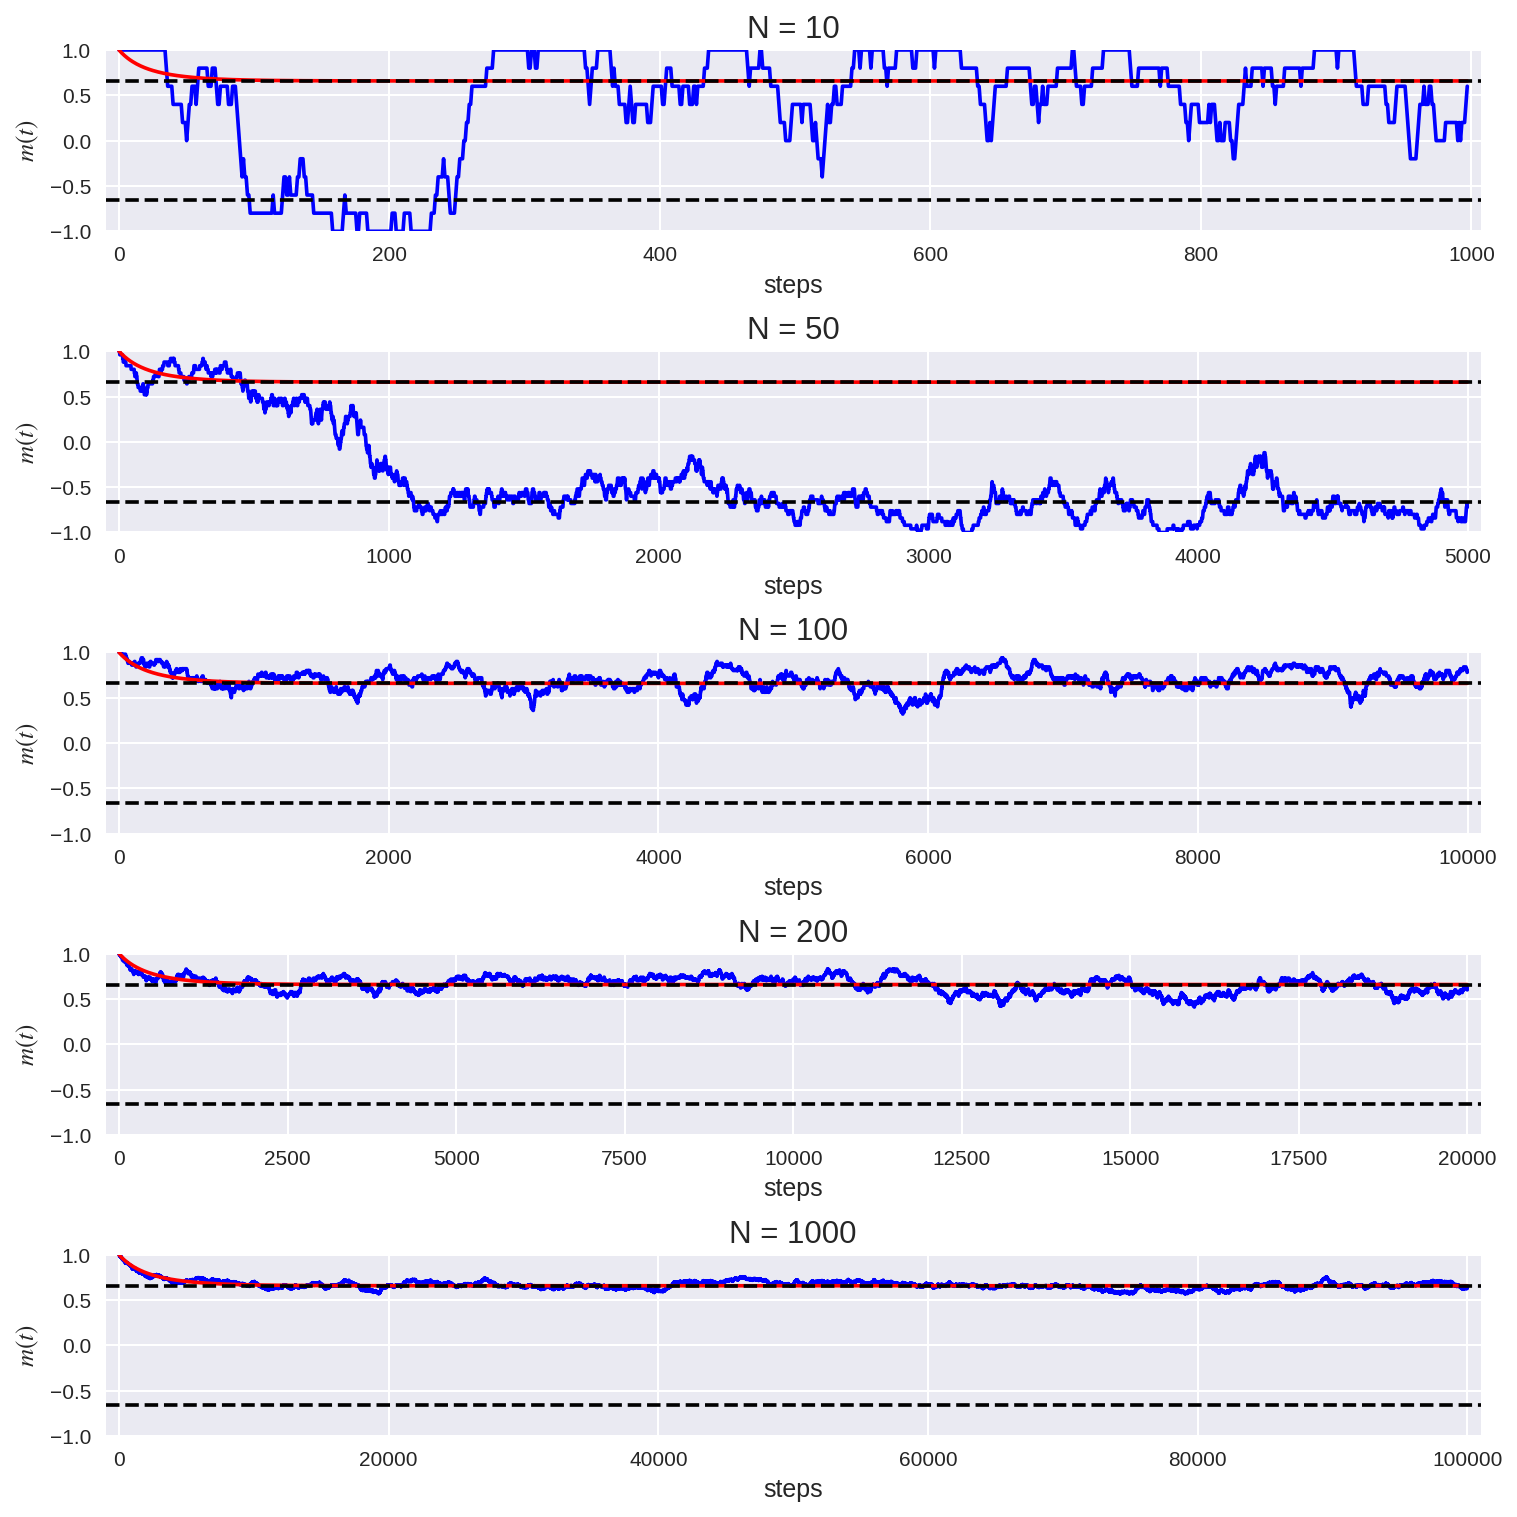

In [18]:
# Case 1:
beta = 1.2
h = 0

mstars = get_mstar(beta, h)

fig, ax = plt.subplots(5, 1, figsize=(10, 10), dpi=150, constrained_layout=True)

for i, N, in enumerate([10, 50, 100, 200, 1000]):
    S0 = np.ones(N) # Start from all ones configuration
    m0 = np.mean(S0)
    
    ms = glauber_MC(beta, h, S0, num_step = 100*N)
    ms_ode = glauber_ode(beta, h, m0, num_step = 100*N, step_size=1/N)
    
    ax[i].plot(ms[:-1], color='b', label='MCMC')
    ax[i].plot(ms_ode[:-1], color='r', label='ODE')

    for mstar in mstars:
        ax[i].axhline(mstar, color='k', ls='--', label='Theory')
        
    ax[i].set_title(f'N = {N}', fontsize=15)
    ax[i].set_xlabel('steps', fontsize=12)
    ax[i].set_ylabel(r'$m(t)$', fontsize=12)
    ax[i].set_ylim([-1,1])


予測通り$N$が小さい領域では, ODEの予測が外れるが, $N \gg 1$のとき予測は当たる

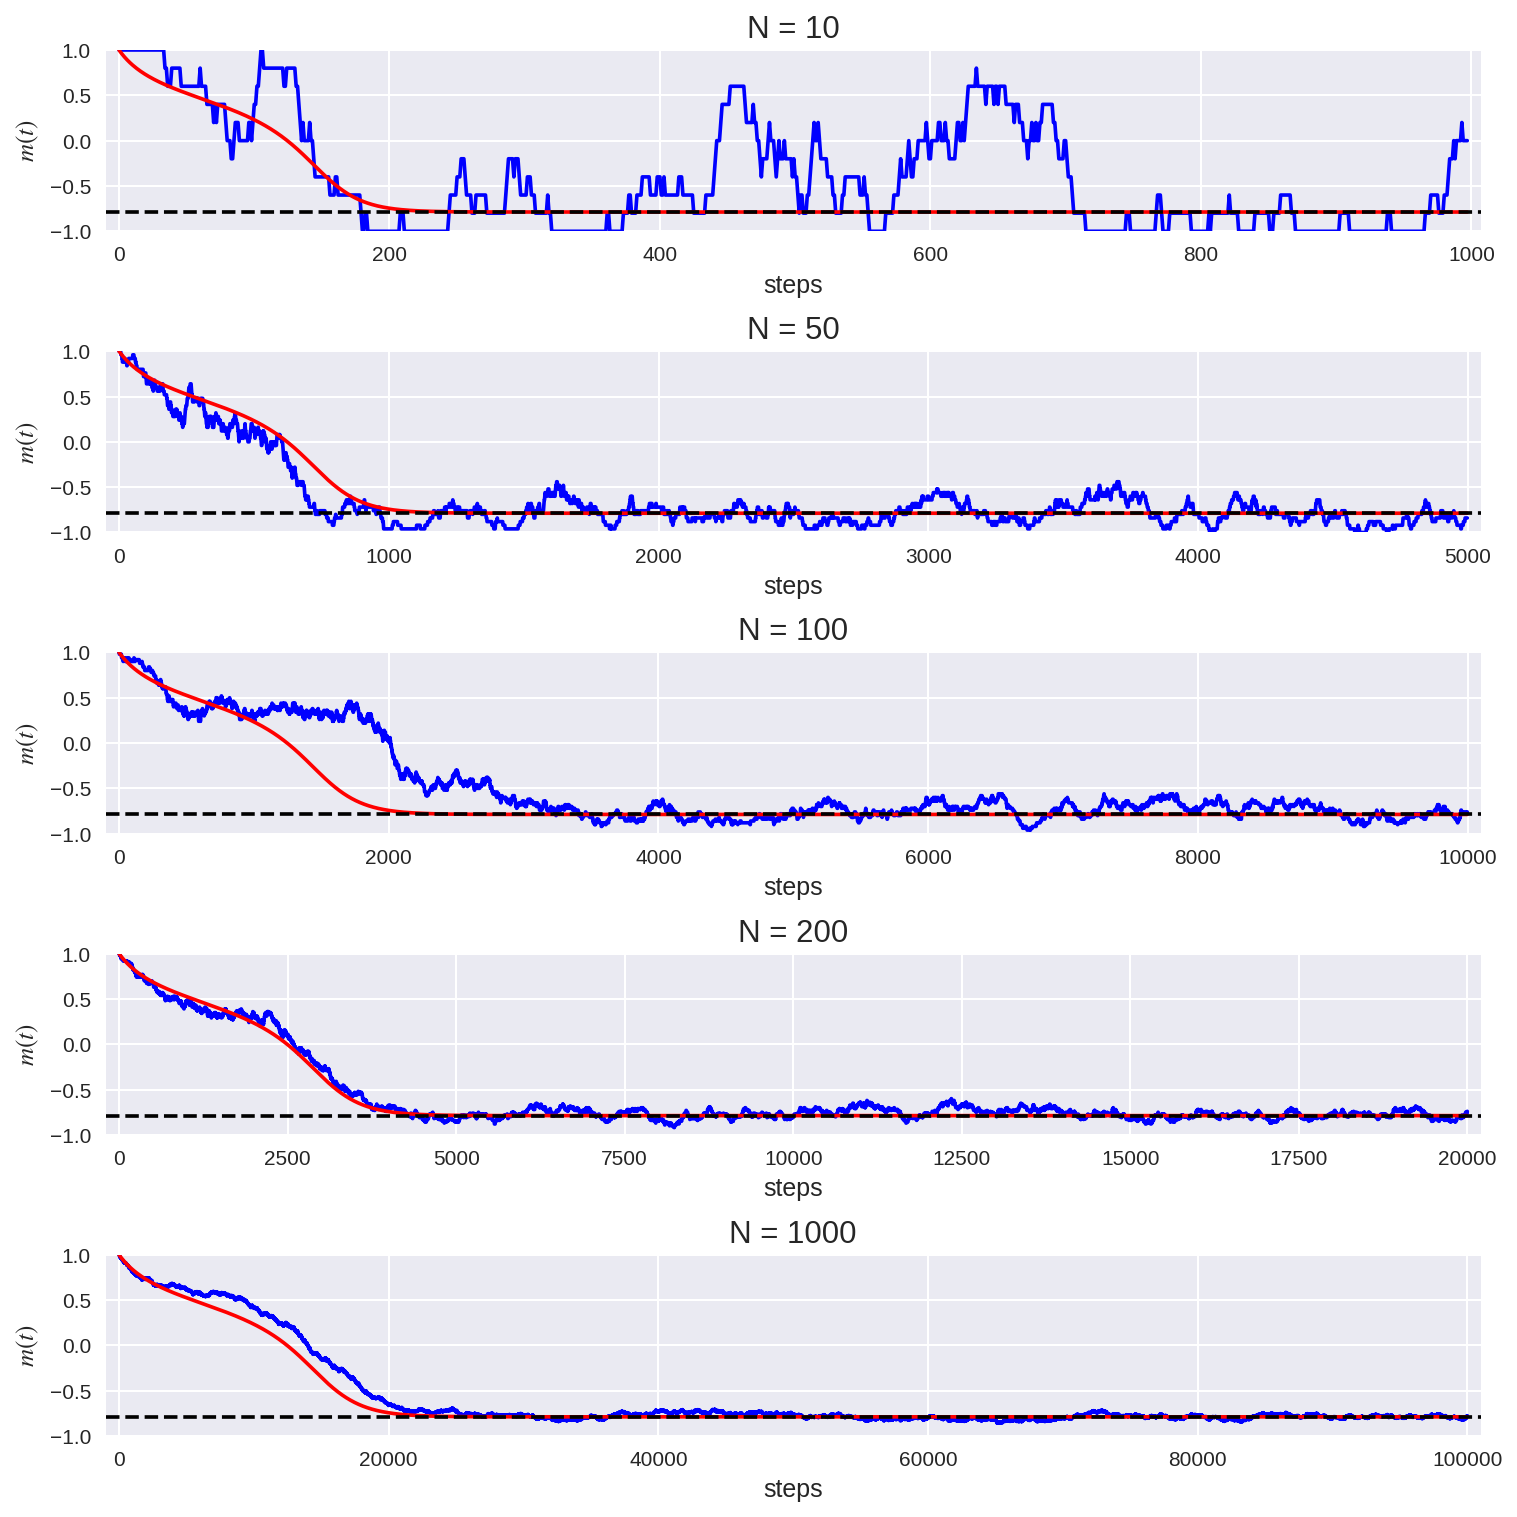

In [19]:
# Case 1:
beta = 1.2
h = -0.1

mstars = get_mstar(beta, h)

fig, ax = plt.subplots(5, 1, figsize=(10, 10), dpi=150, constrained_layout=True)

for i, N, in enumerate([10, 50, 100, 200, 1000]):
    S0 = np.ones(N) # Start from all ones configuration
    m0 = np.mean(S0)
    
    ms = glauber_MC(beta, h, S0, num_step = 100*N)
    ms_ode = glauber_ode(beta, h, m0, num_step = 100*N, step_size=1/N)
    
    ax[i].plot(ms[:-1], color='b', label='MCMC')
    ax[i].plot(ms_ode[:-1], color='r', label='ODE')

    for mstar in mstars:
        ax[i].axhline(mstar, color='k', ls='--', label='Theory')
        
    ax[i].set_title(f'N = {N}', fontsize=15)
    ax[i].set_xlabel('steps', fontsize=12)
    ax[i].set_ylabel(r'$m(t)$', fontsize=12)
    ax[i].set_ylim([-1,1])

Metropolis-Hastings MCとGlauber MCの比較

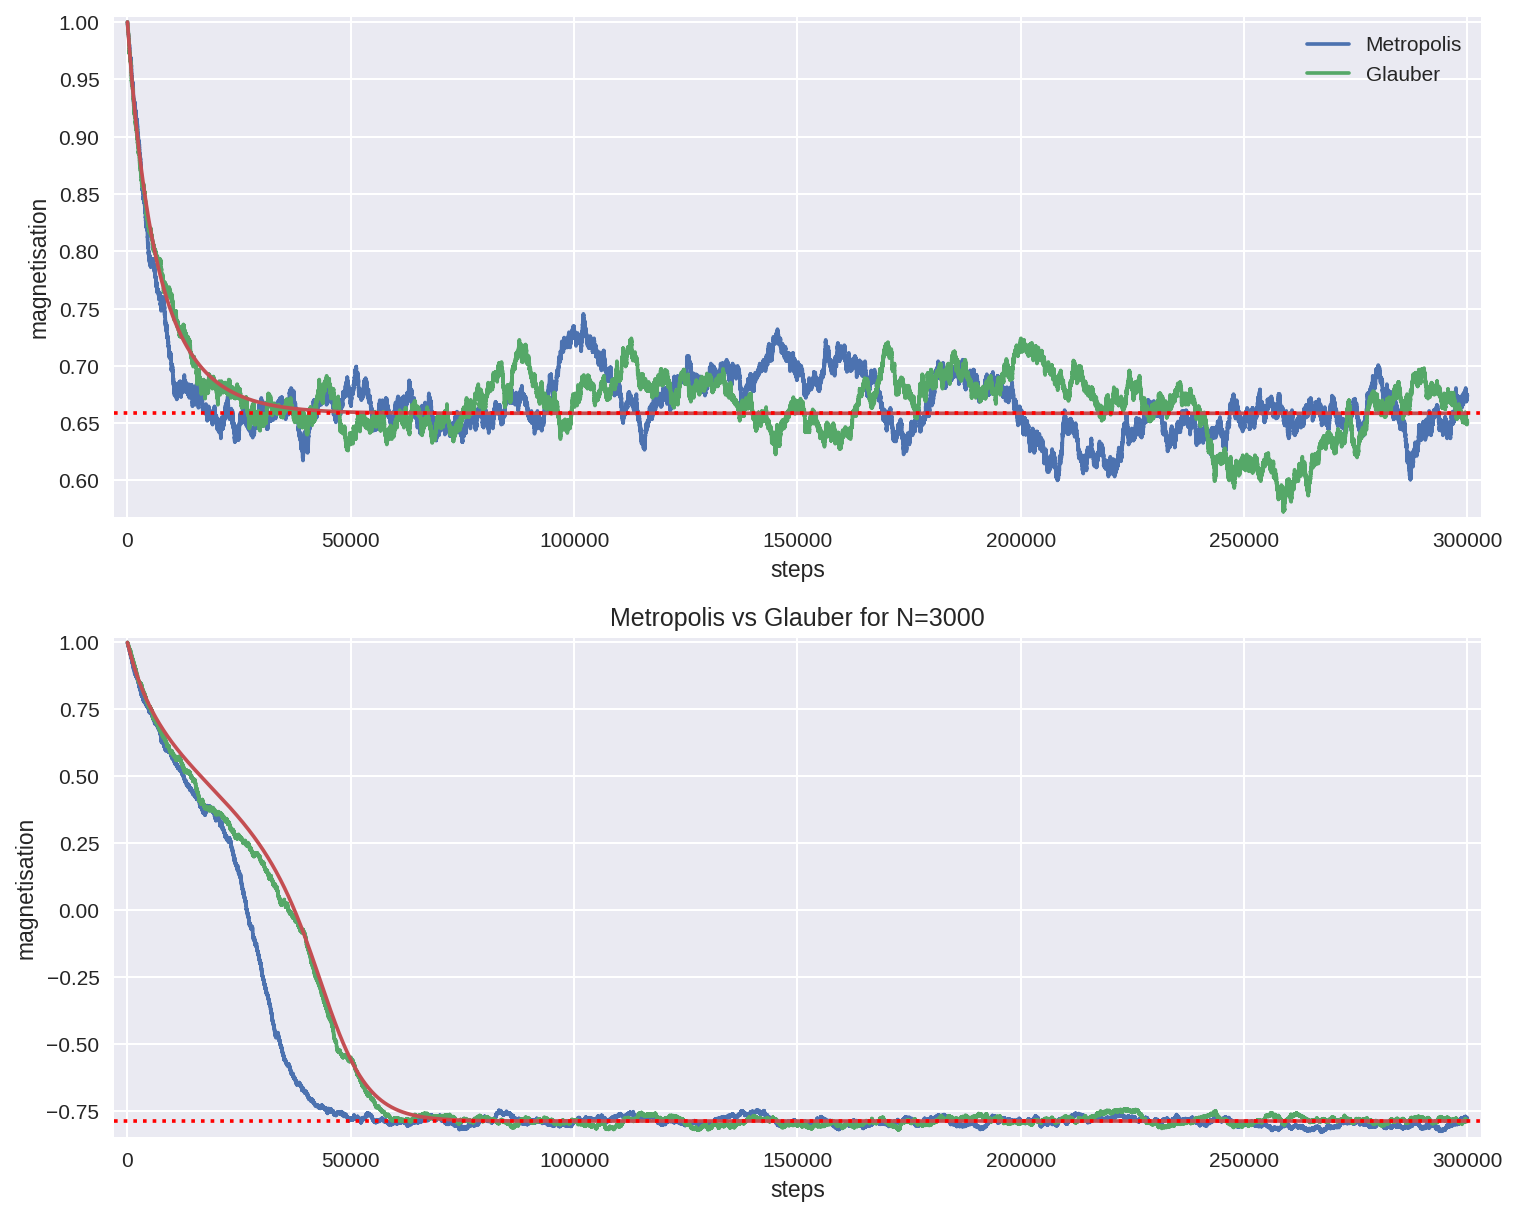

In [21]:
beta = 1.2
N = 3000
fig, ax = plt.subplots(2, 1 , figsize=(10, 8), dpi=150, constrained_layout=True)
plt.title('Metropolis vs Glauber for N=3000')
for i, h in enumerate([0, -0.1]):
    mstars = get_mstar(beta, h)
    mstar = mstars[-1]

    S0 = np.ones(N) # Start from all ones configuration
    m0 = np.mean(S0)

    ms_metropolis = MH_MCMC(beta, h, S0, steps = 100*N)
    ms_glauber = glauber_MC(beta, h, S0, num_step = 100*N)
    ms_ode = glauber_ode(beta, h, m0, num_step = 100*N, step_size=1/N)
    
    ax[i].plot(ms_metropolis[:-1], label='Metropolis')
    ax[i].plot(ms_glauber[:-1], label='Glauber')

    ax[i].plot(ms_ode[:-1])

    ax[i].axhline(mstar, color='red', ls=':')
        
    ax[i].set_xlabel('steps')
    ax[i].set_ylabel(r'magnetisation')
    
ax[0].legend(loc="upper right")